<a href="https://colab.research.google.com/github/Vasundhhara/Belt_prediction_CNN/blob/main/belt_type_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all the necessary libraries

In [ ]:
import ast
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

Mount to google drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The images were uploaded in the drive in a zipped format. This code snippet is used to extract the images within our drive.

In [ ]:
###### !!!!! Don't run ######

import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/belt_data.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/belt_data")
zip_ref.close()

Experiment.csv is the processed file which contains the labels_crops and labels corresponding to each image's index.

In [ ]:
train = pd.read_csv('experiment.csv')    # reading the csv file
train.head()      # printing first five rows of the file

,index,labels_crops,Braided,Canvas,Chain,Leather,Metal,Misc,Punk,Wide
0,1,"[20, 85, 592, 532]",0,0,0,1,0,1,0,0
1,2,"[92, 644, 609, 795]",0,0,0,0,1,0,0,0
2,3,"[78, 18, 267, 130]",0,0,1,0,1,0,0,0
3,4,"[10, 114, 430, 262]",0,0,0,0,1,0,0,0
4,5,"[56, 21, 761, 770]",0,0,1,0,1,0,0,0


This is a sample image before cropping

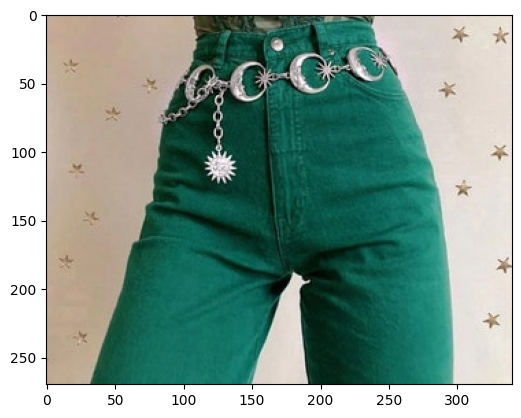

In [ ]:
import keras
from tensorflow.keras.utils import load_img
import matplotlib.image as mpimg


i=3
path= '/content/drive/MyDrive/belt_data/images/'+str(i)+'.jpg'
img = mpimg.imread(path)
plt.imshow(img)

This code snippet is used to crop the images according to given label crops.

In [ ]:
######## Cropping images #########
######## !!!!! Don't run !!!!! ########


from tensorflow.keras.utils import img_to_array
import cv2
import numpy as np
import ast
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from PIL import Image

train_image = []
for i in train['index']:
    path= './content/drive/MyDrive/belt_data/images'+str(i)+'.jpg'
    img = mpimg.imread(path)

    label_crops=train.iloc[i-1,1]
    x1,y1,x2,y2= ast.literal_eval(label_crops)
    crop_img= img[y1:y2, x1:x2]
    cv2.imwrite(str(i)+'.jpg',crop_img)

The images can be cropped in the ImageDataGenerator function just before feeding to the model. Bud due to limited computational resources provided by collab, I preferred to crop all the images and store them in drive. The following code snippet is extracting the images from the zipped folder within google drive.

In [ ]:
###### !!!!! Don't run ######

import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/cropped.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/cropped")
zip_ref.close()

Plotting an image after applying the corresponding labels_crops.

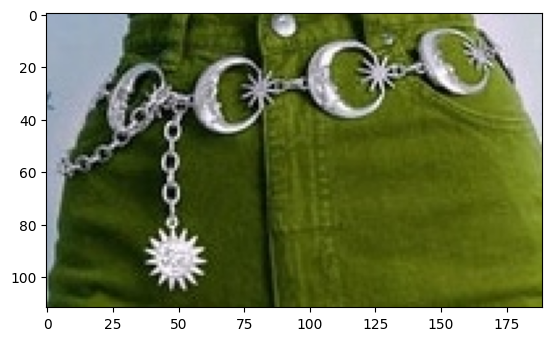

In [ ]:
i=3
path= '/content/drive/MyDrive/cropped/cropped/'+str(i)+'.jpg'
img = mpimg.imread(path)
plt.imshow(img)

Preprocessing the images and converting them into a format suitable to feed the model.

In [ ]:
import keras
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array


train_image = []
for i in tqdm(range(train.shape[0])):
    img = load_img('/content/drive/MyDrive/cropped/cropped/'+str(train['index'][i])+'.jpg',target_size=(200,200,3))
    img = img_to_array(img)

    img = img/255
    train_image.append(img)

100%|██████████| 4513/4513 [00:20<00:00, 215.50it/s]


In [ ]:
X = np.array(train_image)

In [ ]:
X.shape

(4513, 200, 200, 3)

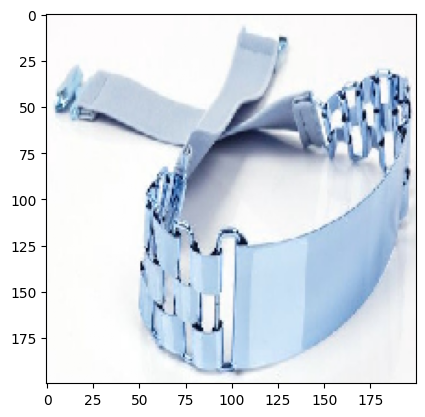

In [ ]:
plt.imshow(X[5])

In [ ]:
Y = np.array(train.drop(['index','labels_crops'],axis=1))

In [ ]:
Y.shape

(4513, 8)

Splitting the data into training and test data.

In [ ]:

X_test = X[3000:,]
Y_test = Y[3000:,]

#Seperation of a validation set from the remaing training set (required for validation while training)

X_train, X_val, Y_train, Y_val = train_test_split(X[:3000,], Y[:3000,], test_size=0.15, random_state=13)

In [ ]:
img_rows, img_cols = 200, 200
input_shape = (img_rows, img_cols, 3)

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 3)

X_val.shape

(450, 200, 200, 3)

Defining the model architecture

In [ ]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(200,200,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 98, 98, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 47, 47, 32)        0

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit( X_train, Y_train,
                    epochs = 15, batch_size = 100,
                    validation_data = (X_val, Y_val))

Epoch 1/15
26/26 [==============================] - 148s 6s/step - loss: 0.5540 - accuracy: 0.2471 - val_loss: 0.5211 - val_accuracy: 0.3200
Epoch 2/15
26/26 [==============================] - 143s 6s/step - loss: 0.4956 - accuracy: 0.3224 - val_loss: 0.4877 - val_accuracy: 0.3200
Epoch 3/15
26/26 [==============================] - 143s 5s/step - loss: 0.4825 - accuracy: 0.3588 - val_loss: 0.4693 - val_accuracy: 0.3200
Epoch 4/15
26/26 [==============================] - 147s 6s/step - loss: 0.4714 - accuracy: 0.3557 - val_loss: 0.4668 - val_accuracy: 0.3200
Epoch 5/15
26/26 [==============================] - 137s 5s/step - loss: 0.4573 - accuracy: 0.3639 - val_loss: 0.4494 - val_accuracy: 0.3200
Epoch 6/15
26/26 [==============================] - 141s 5s/step - loss: 0.4433 - accuracy: 0.3925 - val_loss: 0.4383 - val_accuracy: 0.3844
Epoch 7/15
26/26 [==============================] - 139s 5s/step - loss: 0.4311 - accuracy: 0.3835 - val_loss: 0.4252 - val_accuracy: 0.3822
Epoch 8/15
26

Evaluating the model's accuracy on test data

In [ ]:
model.fit(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test), batch_size=64)

Epoch 1/10
40/40 [==============================] - 150s 4s/step - loss: 0.3466 - accuracy: 0.4659 - val_loss: 0.3175 - val_accuracy: 0.4898
Epoch 2/10
40/40 [==============================] - 151s 4s/step - loss: 0.3327 - accuracy: 0.4859 - val_loss: 0.2917 - val_accuracy: 0.5089
Epoch 3/10
40/40 [==============================] - 151s 4s/step - loss: 0.3216 - accuracy: 0.5008 - val_loss: 0.2877 - val_accuracy: 0.5063
Epoch 4/10
40/40 [==============================] - 149s 4s/step - loss: 0.3048 - accuracy: 0.5082 - val_loss: 0.2878 - val_accuracy: 0.5076
Epoch 5/10
40/40 [==============================] - 150s 4s/step - loss: 0.3122 - accuracy: 0.5004 - val_loss: 0.2898 - val_accuracy: 0.4937
Epoch 6/10
40/40 [==============================] - 150s 4s/step - loss: 0.2889 - accuracy: 0.5169 - val_loss: 0.2831 - val_accuracy: 0.4997
Epoch 7/10
40/40 [==============================] - 150s 4s/step - loss: 0.2860 - accuracy: 0.5298 - val_loss: 0.2792 - val_accuracy: 0.5466
Epoch 8/10
40

Now we'll make some predictions

In [ ]:
img = load_img('/content/drive/MyDrive/cropped/cropped/'+str(train['index'][25])+'.jpg',target_size=(200,200,3))
img = img_to_array(img)
img = img/255

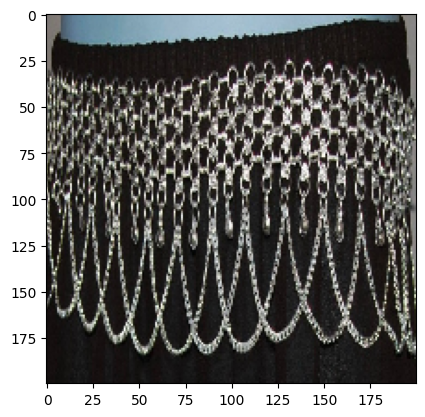

In [ ]:
plt.imshow(img)

1/1 [==============================] - 0s 31ms/step
Metal (0.719)
Misc (0.139)
Chain (0.0613)


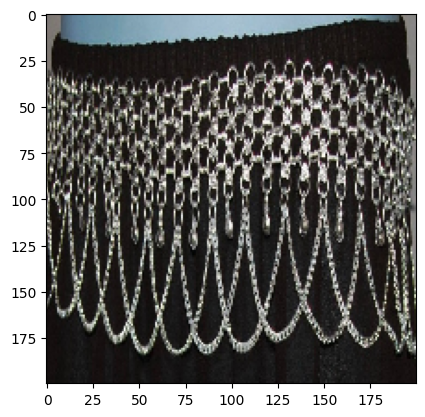

In [ ]:
classes = np.array(train.columns[2:])
prob = model.predict(img.reshape(1,200,200,3))
top_3 = np.argsort(prob[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(prob[0][top_3[i]]))
plt.imshow(img)

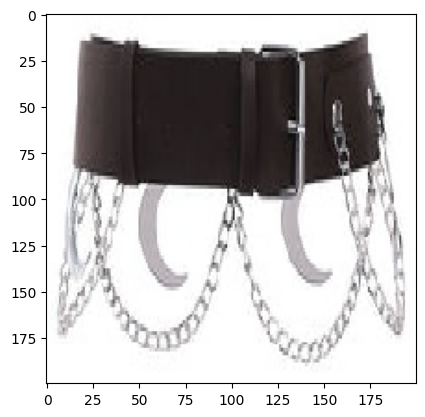

In [ ]:
img = load_img('/content/drive/MyDrive/cropped/cropped/'+str(train['index'][93])+'.jpg',target_size=(200,200,3))
img = img_to_array(img)
img = img/255
plt.imshow(img)

1/1 [==============================] - 0s 30ms/step
Leather (0.683)
Punk (0.256)
Chain (0.0503)


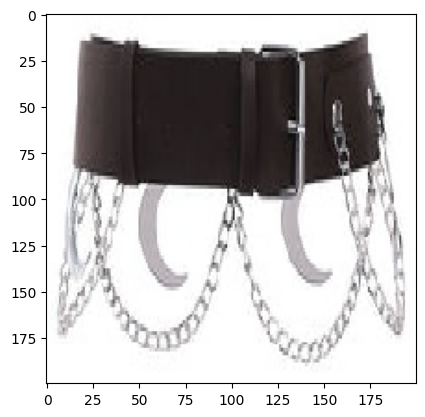

In [ ]:
classes = np.array(train.columns[2:])
prob = model.predict(img.reshape(1,200,200,3))
top_3 = np.argsort(prob[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(prob[0][top_3[i]]))
plt.imshow(img)

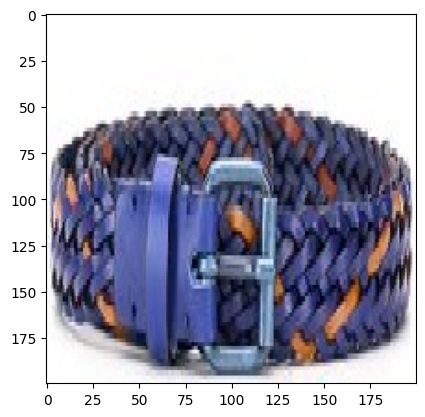

In [ ]:
img = load_img('/content/drive/MyDrive/cropped/cropped/'+str(train['index'][4460])+'.jpg',target_size=(200,200,3))
img = img_to_array(img)
img = img/255
plt.imshow(img)

1/1 [==============================] - 0s 31ms/step
Leather (0.919)
Braided (0.081)
Wide (2.15e-05)


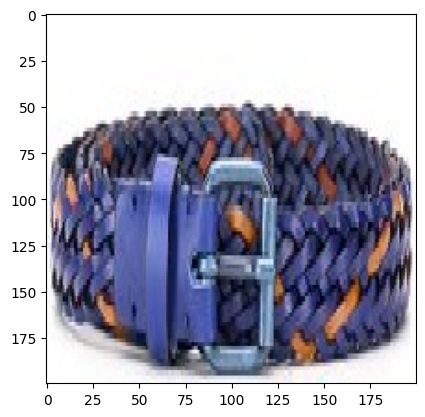

In [ ]:
classes = np.array(train.columns[2:])
prob = model.predict(img.reshape(1,200,200,3))
top_3 = np.argsort(prob[0])[:-4:-1]
for i in range(3):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(prob[0][top_3[i]]))
plt.imshow(img)

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 52.28%
